# Ex: 6.4: Classification Using Scikit-learn

- Objective: We will revisit the World Happiness Report (WHR) data for this exercise, bringing in some additional information that will enable us to formulate a classification problem to predict categorical labels on the dataset. Our goal is to build a classifier that we will train on a subset of the WHR numerical data (x) and the region data (y), so that we can predict regions from data for countries that we have not trained our model on.

- **Requires data files: `WHR2018Chapter2OnlineData.xls`**

- **Demonstrates**:
    - Working with the `StandardScaler` object to standardize the data.
    - `svm` and `tree`  classifiers from scikit-learn to classify the data.
    - Using the `train_test_split` function to split the data into training and testing sets.
    - `accuracy_score` to evaluate the performance of the classifier.

---

Execute the code cell below to import some modules and read in and preprocess the WHR data as we have done previously.  The last line in the code cell below returns the head of the basic WHR dataframe, to remind you what is in that dataset.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

dfraw = pd.read_excel('WHR2018Chapter2OnlineData.xls', sheet_name='Table2.1')
cols_to_include = ['country', 'year', 'Life Ladder', 
                   'Positive affect','Negative affect',
                   'Log GDP per capita', 'Social support',
                   'Healthy life expectancy at birth', 
                   'Freedom to make life choices', 
                   'Generosity', 'Perceptions of corruption']
renaming = {'Life Ladder': 'Happiness', 
            'Log GDP per capita': 'LogGDP', 
            'Social support': 'Support', 
            'Healthy life expectancy at birth': 'Life', 
            'Freedom to make life choices': 'Freedom', 
            'Perceptions of corruption': 'Corruption', 
            'Positive affect': 'Positive', 
            'Negative affect': 'Negative'}
df = dfraw[cols_to_include].rename(renaming, axis=1)
key_vars = ['Happiness', 'LogGDP', 'Support', 'Life', 'Freedom', 'Generosity', 'Corruption', 'Positive', 'Negative']
df.head()

,country,year,Happiness,Positive,Negative,LogGDP,Support,Life,Freedom,Generosity,Corruption
0,Afghanistan,2008,3.723590,0.517637,0.258195,7.168690,0.450662,49.209663,0.718114,0.181819,0.881686
1,Afghanistan,2009,4.401778,0.583926,0.237092,7.333790,0.552308,49.624432,0.678896,0.203614,0.850035
2,Afghanistan,2010,4.758381,0.618265,0.275324,7.386629,0.539075,50.008961,0.600127,0.137630,0.706766
3,Afghanistan,2011,3.831719,0.611387,0.267175,7.415019,0.521104,50.367298,0.495901,0.175329,0.731109
4,Afghanistan,2012,3.782938,0.710385,0.267919,7.517126,0.520637,50.709263,0.530935,0.247159,0.775620


### Step 1.

We will first augment the core WHR dataset that we have been working with to bring in some additional information that is included in a different worksheet in the WHR spreadsheet.  Since this is mostly about data processing rather than machine learning, simply execute the next two code cells below.  But study each line of code and the associated comments, and then examine the head of the new dataframe named ```df2``` to understand what has been done.

In [2]:
# read in data from SupportingFactors worksheet into a new dataframe dfsupp
dfsupp = pd.read_excel('WHR2018Chapter2OnlineData.xls', sheet_name='SupportingFactors')

# extract out region information from SupportingFactors dataframe
regions = dfsupp[['country', 'Region indicator']].rename({'Region indicator': 'region'}, axis=1)

# examine head of regions dataframe -- each country has an associated world region
regions.head()

,country,region
0,Afghanistan,South Asia
1,Albania,Central and Eastern Europe
2,Algeria,Middle East and North Africa
3,Angola,Sub-Saharan Africa
4,Argentina,Latin America and Caribbean


In [3]:
# compute the mean values of all the WHR data for each country, averaging over all years in the dataset
dfmean = df.groupby('country').mean().drop('year', axis=1)

# merge the mean WHR data with the region information extracted previously
df2 = pd.merge(dfmean, regions, on='country').dropna()

# set the index of df2 to be the country name
df2.set_index('country', inplace=True)

# examine head of df2 dataframe -- mean WHR values for each country, along with associated regions
df2.head()

,Happiness,Positive,Negative,LogGDP,Support,Life,Freedom,Generosity,Corruption,region
country,,,,,,,,,,
Afghanistan,3.806614,0.580873,0.301283,7.419697,0.517146,50.838271,0.544895,0.118428,0.826794,South Asia
Albania,4.988791,0.642628,0.303256,9.247059,0.723204,68.027213,0.626155,-0.105019,0.859691,Central and Eastern Europe
Algeria,5.555004,0.616524,0.265460,9.501728,0.804633,64.984461,0.536398,-0.208236,0.661478,Middle East and North Africa
Angola,4.420299,0.613339,0.351173,8.713935,0.737973,51.729801,0.455957,-0.077940,0.867018,Sub-Saharan Africa
Argentina,6.406131,0.840998,0.273187,9.826051,0.906080,66.764205,0.753122,-0.154544,0.844038,Latin America and Caribbean


### Step 2.

It is this new dataframe ```df2``` that we want to use for machine learning.  For each country in the dataset, we have a set of mean numerical values ('Happiness', 'Positive', 'Negative', etc., which are all listed in the variable ```key_vars``` defined above) and a categorical value ('region').  

#### We would like to know if the raw numerical data are  predictive of the region.  In other words, if someone gave you a set of numerical data on Happiness, etc. for an unknown country, would you be able to predict what region of the world it might be located in?  This is an example of classification, where we will train a model based on the numerical data and the associated labels (regions).

In order to proceed, we first want to extract and process some data from our ```df2``` dataframe.  We need to separate the data into two parts:
* the ```region data``` that we want to be able to predict (we'll call it ```y```)
* the ```WHR numerical data``` that we want to use as input to our prediction (we'll call it ```x```)

In the code cell below:
* Extract the subset of ```df2``` associated with the columns in ```key_vars``` and assign it to the variable ```x```.
* Extract the subset of ```df2``` associated with the region column, and assign it to the variable ```y```.
* Print the shape of both `x` and `y`.

In [4]:
# Extract the subset of df2 associated with the columns in key_vars and assign it to the variable x.
x = df2[key_vars]

# Extract the subset of df2 associated with the region column, and assign it to the variable y.
y = df2['region']

# Print the shape of both x and y.
print("Shape of x:", x.shape)
print("Shape of y:", y.shape)

Shape of x: (152, 9)
Shape of y: (152,)


### Step 3.

You should note that the shape of ```x``` is (152, 9) and the shape of ```y``` is (152,).  This is similar to what we saw in the earlier exercise on hand-written digits!  There are 152 samples (countries), and 9 features (each of the key_vars) that we are making predictions from.

Because the numerical data columns in ```x``` represent different quantities and have different scales, we have to preprocess the data some more to remove that source of variation. We will use one here called ```StandardScaler```, which will transform a data set so that each resulting column has zero mean and unit standard deviation. More about Standardization the the StandardScaler class can be found [here](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-scaler).

First examine, and then execute the code cell below.  This code does the following:
* imports the `StandardScaler` object
* creates and fits a `StandardScaler` object to our dataframe ```x```
* creates a new dataframe ```x_scaled``` that contains the scaled (transformed) data, using the column and index labels from the unscaled dataframe ```x```
* prints out the mean and standard deviation of each column of ```x_scaled```
* peeks at the head of the new dataframe ```x_scaled```

In examining the output, check that the means of each column have been scaled to nearly zero (to within a very small tolerance) and the standard deviations have been scaled to one. Some of the very small numbers might be printed out in scientific notation, where a number like ```1.928282e-16``` means ```1.928282 * 10**(-16)```.

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(x)
x_scaled = pd.DataFrame(scaler.fit_transform(x), columns = x.columns, index = x.index)

print(np.mean(x_scaled, axis=0))
print(np.std(x_scaled, axis=0))

x_scaled.head()

Happiness     1.782200e-16
LogGDP        6.135443e-17
Support      -2.337312e-16
Life         -5.843279e-17
Freedom       6.748987e-16
Generosity    1.168656e-17
Corruption    9.349247e-17
Positive      1.811417e-16
Negative      2.337312e-16
dtype: float64
Happiness     1.0
LogGDP        1.0
Support       1.0
Life          1.0
Freedom       1.0
Generosity    1.0
Corruption    1.0
Positive      1.0
Negative      1.0
dtype: float64


,Happiness,LogGDP,Support,Life,Freedom,Generosity,Corruption,Positive,Negative
country,,,,,,,,,
Afghanistan,-1.443128,-1.438896,-2.425953,-1.333584,-1.397623,0.735439,0.451854,-1.262731,0.471370
Albania,-0.360792,0.054466,-0.681799,0.776161,-0.776670,-0.719736,0.632648,-0.638194,0.499009
Algeria,0.157600,0.262588,0.007447,0.402698,-1.462554,-1.391919,-0.456675,-0.902184,-0.030449
Angola,-0.881273,-0.381215,-0.556782,-1.224159,-2.077245,-0.543385,0.672914,-0.934399,1.170248
Argentina,0.936845,0.527632,0.866136,0.621142,0.193546,-1.042257,0.546624,1.367958,0.077797


### Step 4.

Now that the data have been preprocessed, we can begin with our classification analysis. Execute the code cell below to import:
* the ```svm``` and ```tree``` submodules
* the ```train_test_split``` function
* the ```accuracy_score``` function


In [6]:
from sklearn import svm, tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

### Step 5.

One of the functions that we imported above is called ```train_test_split```.  As its name suggests, this function splits a dataset into separate training and testing sets.  The [online documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html?highlight=train_test_split#sklearn-model-selection-train-test-split) indicates that it splits a dataset randomly, such that approximately 25% of the data winds up in the test set and the remaining 75% in the training set.  Here, we want to split up 2 arrays (```x_scaled``` and ```y```) into coordinated test and train sets, so that the function will return a total of 4 subarrays (```x_train, x_test, y_train, y_test```).

In the code cell below, enter and execute a call to ```train_test_split``` that takes ```x_scaled``` and ```y``` as inputs, along with the optional parameter ```random_state=0```, and returns the 4 data subsets mentioned above, to be named as ```x_train```, ```x_test```, ```y_train```, ```y_test```.  The online documentation provides an example of what such a function call looks like. After the function call, print the shapes of each of the four arrays that are returned.
- ```random_state``` set to 0 will ensure that the same random split is generated each time the function is called. 

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, random_state=0)
print("Shape of x_train:", x_train.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of x_train: (114, 9)
Shape of x_test: (38, 9)
Shape of y_train: (114,)
Shape of y_test: (38,)


### Step 6.

Having split our datasets, we want to first train a classifier on our training data so that we can apply it to the testing data.  One way of assessing the performance of a classifier is by computing its accuracy score on the test data, that is, what fraction of the test data are correctly predicted by the classifier.  Fortunately, `sklearn` provides a built-in function named ```accuracy_score``` that carries out this computation. You can read more about it in the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html?highlight=accuracy_score#sklearn.metrics.accuracy_score).


We will first build the SVM Classifier. In the code cell below:
* create a new ```svm.SVC()``` object and assign it to the variable ```clf1``` 
* call the ```fit``` method on ```clf1``` with the `x` and `y` training data (i.e., training the model to associate ```x_train``` with ```y_train```)
* call the ```predict``` method on ```clf1``` on the `x` testing data and assign the result to the variable ```predictions1```, in order to make predictions for those inputs
* call the ```accuracy_score``` function on the `y` testing data and the test predictions you generated and assign the result to the variable ```score1```
* print the value of ```score1```

The accuracy score is a fraction between 0 and 1 indicating the fraction of predictions that match the true value in the test set. The accuracy score reported should be around 71% (0.71).

In [13]:
clf1 = svm.SVC()
clf1.fit(x_train, y_train)
predictions1 = clf1.predict(x_test)
score1 = accuracy_score(y_test, predictions1)
print("SVM Accuracy:", score1)

SVM Accuracy: 0.7105263157894737


### Step 7.

Build a second classifier based on Decision Trees as supported by the ```tree``` module.

In the code cell below:

* Create a new ```tree.DecisionTreeClassifier()``` object with the optional argument ```random_state=0```, and assign it to the variable ```clf2``` (`clf2` stands for "classifier number 2", so that we can compare with ```clf1``` above).
* Call the ```fit``` method on ```clf2``` with the `x` and `y` training data (i.e., training the model to associate ```x_train``` with ```y_train```).
* Call the ```predict``` method on ```clf2``` on the `x` testing data and assign the result to the variable ```predictions2```, in order to make predictions for those inputs.
* Call the ```accuracy_score``` function on the `y` testing data and the test predictions you generated and assign the result to the variable ```score2```.
* Print the value of ```score2```.

In [14]:
clf2 = tree.DecisionTreeClassifier(random_state=0)
clf2.fit(x_train, y_train)
predictions2 = clf2.predict(x_test)
score2 = accuracy_score(y_test, predictions2)
print("Decision Tree Accuracy:", score2)


Decision Tree Accuracy: 0.7631578947368421


### Step 8.
#### Compare the classifiers.

Given that ```train_test_split``` can produce different random splits, let's compare the two classifiers &mdash; ```clf1``` (SVM) and ```clf2``` (Decision Tree) &mdash; for different splits.

In the code cell below, write some code to do the following:
* write a Python `for` loop so that you can run through the loop 20 times
* within each pass through the loop, do the following:
    * call `test_train_split` on ```x_scaled``` and ```y``` to get new random instances of `x_train`, `x_test`, `y_train`, `y_test` -- in this case, you don't want to pass in a value for ```random_state``` since you want to get different random splits each time
    * fit each of the classifiers `clf1` and `clf2` to `x_train` and `y_train`
    * run predictions on each of the classifiers `clf1` and `clf2` on the `x` testing data
    * compute the accuracy_score of each of the two classifiers on the test data and the test predictions you generated 
    * print the score of each classifier, as well as their difference (hint: ```print(score1, score2, score1-score2)``` to get just one line of output per iteration of the loop)
    
Execute the code you have written.  You should see it run through the loop 20 times, for different random data splits. 


In [16]:
for i in range(20):
    x_train, x_test, y_train, y_test = train_test_split(x_scaled, y)
    clf1.fit(x_train, y_train)
    predictions1 = clf1.predict(x_test)
    score1 = accuracy_score(y_test, predictions1)

    clf2.fit(x_train, y_train)
    predictions2 = clf2.predict(x_test)
    score2 = accuracy_score(y_test, predictions2)

    print(score1, score2, score1 - score2)

0.6052631578947368 0.631578947368421 -0.02631578947368418
0.631578947368421 0.6052631578947368 0.02631578947368418
0.6052631578947368 0.6052631578947368 0.0
0.6052631578947368 0.631578947368421 -0.02631578947368418
0.5 0.4473684210526316 0.05263157894736842
0.6052631578947368 0.6842105263157895 -0.07894736842105265
0.7631578947368421 0.5789473684210527 0.1842105263157895
0.631578947368421 0.631578947368421 0.0
0.631578947368421 0.4473684210526316 0.18421052631578944
0.6578947368421053 0.5789473684210527 0.07894736842105265
0.5789473684210527 0.6842105263157895 -0.10526315789473684
0.6052631578947368 0.5526315789473685 0.05263157894736836
0.7631578947368421 0.6052631578947368 0.1578947368421053
0.6842105263157895 0.5526315789473685 0.13157894736842102
0.47368421052631576 0.5263157894736842 -0.05263157894736842
0.7105263157894737 0.631578947368421 0.07894736842105265
0.7368421052631579 0.631578947368421 0.10526315789473684
0.5789473684210527 0.47368421052631576 0.10526315789473689
0.7631

### Step 9.

Generate a visual summary of the relative performance of the two classifiers, for a larger number of runs.

In the code cell below, copy and paste the code you wrote above and modify it to do the following:

* prior to entering the `for` loop, initialize two empty lists named ```all_scores1``` and ```all_scores2``` that will be used to collect the scores of each classifier each time through the loop
* run through the loop 1000 times instead of 20 as before
* append the scores (```score1``` and ```score2```) to each of the lists used to contain all the scores
* remove the print statement so that you don't get 1000 annoying print statements when you run the code
* once the loop is finished, use the ```plt.hist``` function to plot histograms for ```all_scores1``` and ```all_scores2``` together in the same plot
    * you can accomplish this by making two successive calls to the histogram function within the same code cell
    * you might want to add options to change the number of bins for the histograms
    * you should change the alpha value (opacity) of the histogram plots so that you can see both distributions, since at full opacity, the second one plotted will obscure the first one
    * you should use the ``label`` option to label the datasets
* After making your two calls to ```plt.hist```, you should call ``plt.legend`` to produce a legend on the plot that will identify the two datasets based on the label options that you added to your ```plt.hist``` calls

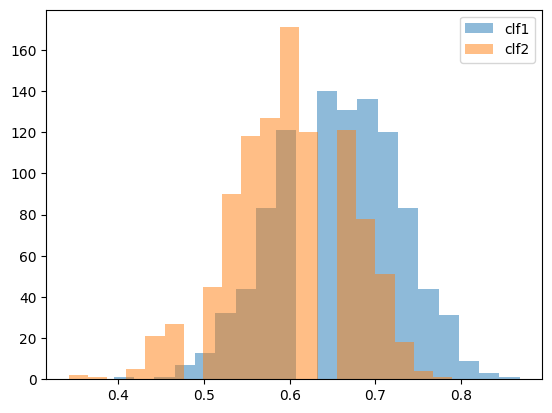

In [22]:
all_scores1 = []
all_scores2 = []

for i in range(1000):
    x_train, x_test, y_train, y_test = train_test_split(x_scaled, y)
    clf1.fit(x_train, y_train)
    predictions1 = clf1.predict(x_test)
    score1 = accuracy_score(y_test, predictions1)
    all_scores1.append(score1)

    clf2.fit(x_train, y_train)
    predictions2 = clf2.predict(x_test)
    score2 = accuracy_score(y_test, predictions2)
    all_scores2.append(score2)  
    
plt.hist(all_scores1, bins=20, alpha=0.5, label='clf1')
plt.hist(all_scores2, bins=20, alpha=0.5, label='clf2')
plt.legend(loc='upper right')